In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
plt.style.use('ggplot')
import seaborn as sns
pd.options.display.float_format = '{:,.0f}'.format
from IPython.display import display
import dataframe_image as dfi
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
encoder = OneHotEncoder(sparse_output=False)
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
#widgets.IntSlider()

In [3]:
#Import Imputeed Ames Data
Ames = pd.read_csv('Ames_HousePrice_Imputed.csv')

#Update with new Ames Data
Ames_Columns_Numeric = Ames[[
    '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath',
    'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr',
    'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'MoSold',
    'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'TotRmsAbvGrd', 'WoodDeckSF',
    'YearBuilt', 'YearRemodAdd', 'YrSold'
]]
Ames_Columns_Ordinal = Ames[[ 
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
    'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Functional',
    'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual',
    'LandSlope', 'LotShape', 'OverallCond', 'OverallQual', 'PavedDrive',
    'PoolQC', 'Utilities'
]]
Ames_Columns_Nominal = Ames[[ 
    'Alley', 'BldgType', 'CentralAir', 'Condition1', 'Condition2',
    'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating',
    'HouseStyle', 'LandContour', 'LotConfig', 'MasVnrType', 'MiscFeature',
    'MSSubClass', 'MSZoning', 'Neighborhood', 'RoofMatl', 'RoofStyle',
    'SaleCondition', 'SaleType', 'Street'
]].astype(str)

#Combination Table of Numeric & Ordinal Columns
Ames_Columns_Numeric_Ordinal = Ames[
    list(Ames_Columns_Numeric.columns) + list(Ames_Columns_Ordinal.columns)
]
#Combination Table of Nominal & Ordinal Columns
Ames_Columns_Nominal_Ordinal = Ames[
    list(Ames_Columns_Nominal.columns) + list(Ames_Columns_Ordinal.columns)
]

In [4]:
encoder = OneHotEncoder(sparse_output=False)
encoder_nominal = OneHotEncoder(sparse_output=False)
encoder_ordinal = OneHotEncoder(sparse_output=False)
Nominal_cols = Ames_Columns_Nominal.columns
Ordinal_cols = Ames_Columns_Ordinal.columns
Numeric_cols = Ames_Columns_Numeric.columns

#One-Hot Encode Nominal
Ames_Optimal_Nominal_One_Hot = encoder_nominal.fit_transform(Ames[Nominal_cols])
Ames_Optimal_Nominal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Nominal_One_Hot,
    columns=encoder_nominal.get_feature_names_out(Nominal_cols),
    index=Ames.index
)
#DO NOT One-Hot Encode Ordinal (for now)
Ames_Optimal_Ordinal_One_Hot = Ames_Columns_Ordinal #encoder_ordinal.fit_transform(Ames[Ordinal_cols])
Ames_Optimal_Ordinal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Ordinal_One_Hot,
    #columns=encoder_ordinal.get_feature_names_out(Ordinal_cols),
    index=Ames.index
)
#Merge Nominal & Ordinal Encodings
Ames_Optimal_Categorical_One_Hot = pd.merge(
    Ames_Optimal_Nominal_One_Hot_df,
    Ames_Optimal_Ordinal_One_Hot_df,
    left_index=True,
    right_index=True,
    how='left'
)
#Merge with Numeric Features
Ames_MLR_Optimal_Columns = pd.merge(
    Ames[Numeric_cols],
    Ames_Optimal_Categorical_One_Hot,
    left_index=True,
    right_index=True,
    how='left'
)

In [5]:
Y = Ames['SalePrice']
X = Ames_MLR_Optimal_Columns

In [6]:
def Plot_Feature_SHAP_Importances(model, model_name, X=X, top_n=20, use_all_rows=True, max_estimators=20):
    pd.reset_option("display.float_format")
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    
    #Feature Importances
    importances = None
    if hasattr(best_model, 'estimators_') and hasattr(best_model.estimators_[0], 'feature_importances_'):
        #Bagging with tree base estimators
        if max_estimators < len(best_model.estimators_):
            selected_estimators = np.random.choice(best_model.estimators_, size=max_estimators, replace=False)
        else:
            selected_estimators = best_model.estimators_
        importances = np.mean([est.feature_importances_ for est in selected_estimators], axis=0)
    elif hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif model_name.lower().startswith('cat') and hasattr(best_model, 'get_feature_importance'):
        importances = best_model.get_feature_importance()
    
    if importances is None:
        print(f'{model_name} does not expose native feature importances.')
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.nan})
    else:
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': np.round(importances, 4)
        }).sort_values('Importance', ascending=False)
        
        #Plot Top Feature Importances
        top_features = feature_importance_df.head(top_n)
        plt.figure(figsize=(8,6))
        plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='teal')
        plt.xlabel('Feature Importance')
        plt.title(f'{model_name} - Top {top_n} Feature Importances')
        plt.tight_layout()
        plt.show()
    
    #SHAP Values
    X_sample = X.copy() if use_all_rows else X.sample(min(500, X.shape[0]), random_state=2)
    try:
        # Bagging tree-based models: subsample estimators for SHAP
        if hasattr(best_model, 'estimators_'):
            if max_estimators < len(best_model.estimators_):
                selected_estimators = np.random.choice(best_model.estimators_, size=max_estimators, replace=False)
                temp_model = best_model.__class__(base_estimator=best_model.estimators_[0], n_estimators=max_estimators)
                temp_model.estimators_ = selected_estimators
                explainer = shap.TreeExplainer(temp_model)
            else:
                explainer = shap.TreeExplainer(best_model)
        elif hasattr(best_model, 'tree_') or 'Tree' in str(type(best_model)):
            explainer = shap.TreeExplainer(best_model)
        else:
            explainer = shap.Explainer(best_model, X_sample)
        shap_values = explainer(X_sample)
    except Exception:
        explainer = shap.Explainer(best_model.predict, X_sample)
        shap_values = explainer(X_sample)
    
    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values
    shap_abs_mean = np.abs(shap_vals).mean(axis=0)
    
    shap_value_df = pd.DataFrame({
        'Feature': X_sample.columns,
        '|SHAP value|': shap_abs_mean
    }).sort_values('|SHAP value|', ascending=False)
    
    #Plot Top SHAP values
    top_shap = shap_value_df.head(top_n)
    plt.figure(figsize=(8,6))
    plt.barh(top_shap['Feature'][::-1], top_shap['|SHAP value|'][::-1], color='cornflowerblue')
    plt.xlabel('|SHAP value| (Avg Impact)')
    plt.title(f'{model_name} - Top {top_n} SHAP Feature Values')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
    plt.tight_layout()
    plt.show()
    
    #Merge Feature Importance & SHAP
    feature_shap_df = pd.merge(feature_importance_df, shap_value_df, on='Feature', how='outer')
    feature_shap_df = feature_shap_df.sort_values('Importance', ascending=False)
    feature_shap_df_top = feature_shap_df.head(top_n).copy()
    y_pos = np.arange(len(feature_shap_df_top))
    
    #Side by Side Plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True)
    
    #Feature Importance subplot
    ax1.barh(y_pos, feature_shap_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(feature_shap_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Feature Importance')
    ax1.set_title(f'{model_name} - Top {top_n} Feature Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
    
    #SHAP values subplot
    ax2.barh(y_pos, feature_shap_df_top['|SHAP value|'], color='cornflowerblue')
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'{model_name} - Top {top_n} SHAP Feature Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
    
    plt.tight_layout()
    plt.show()

    #Top 20 Table
    display(feature_shap_df.head(top_n).style.format({'Importance': '{:.4f}', '|SHAP value|': '{:,.0f}'}))

In [7]:
def Plot_HGB_Feature_SHAP_Importances(model, X=X, Y=Y, top_n=20, use_all_rows=True, n_permutations=10):
    pd.reset_option("display.float_format")
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    
    #Permutation Feature Importances
    perm_imp = permutation_importance(best_model, X, Y, n_repeats=n_permutations, random_state=2, n_jobs=-1)
    
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_imp.importances_mean
    }).sort_values('Importance', ascending=False)
    
    #Plot Top Permutation Importances
    top_features = feature_importance_df.head(top_n)
    plt.figure(figsize=(8,6))
    plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='teal')
    plt.xlabel('Permutation Importance')
    plt.title(f'HistGradientBoostingRegressor - Top {top_n} Permutation Importances')
    plt.tight_layout()
    plt.show()
    
    # SHAP Values
    X_sample = X.copy() if use_all_rows else X.sample(min(500, X.shape[0]), random_state=2)
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer(X_sample)
    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values
    shap_abs_mean = np.abs(shap_vals).mean(axis=0)
    
    shap_value_df = pd.DataFrame({
        'Feature': X_sample.columns,
        '|SHAP value|': shap_abs_mean
    }).sort_values('|SHAP value|', ascending=False)
    
    #Plot Top SHAP values
    top_shap = shap_value_df.head(top_n)
    plt.figure(figsize=(8,6))
    plt.barh(top_shap['Feature'][::-1], top_shap['|SHAP value|'][::-1], color='cornflowerblue')
    plt.xlabel('|SHAP value| (Avg Impact)')
    plt.title(f'HistGradientBoostingRegressor - Top {top_n} SHAP Values')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.3f}'))
    plt.tight_layout()
    plt.show()
    
    #Merge Feature Importance & SHAP
    feature_shap_df = pd.merge(feature_importance_df, shap_value_df, on='Feature', how='outer')
    feature_shap_df = feature_shap_df.sort_values('Importance', ascending=False)
    feature_shap_df_top = feature_shap_df.head(top_n).copy()
    y_pos = np.arange(len(feature_shap_df_top))
    
    #Side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True)
    
    #Permutation Importance subplot
    ax1.barh(y_pos, feature_shap_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(feature_shap_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Permutation Importance')
    ax1.set_title(f'HistGradientBoostingRegressor - Top {top_n} Permutation Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.3f}'))
    
    #SHAP Values subplot
    ax2.barh(y_pos, feature_shap_df_top['|SHAP value|'], color='cornflowerblue')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([])
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'HistGradientBoostingRegressor - Top {top_n} SHAP Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.3f}'))
    
    plt.tight_layout()
    plt.show()
    
    #Top 20 table
    display(feature_shap_df_top.style.format({'Importance': '{:.4f}', '|SHAP value|': '{:,.0f}'}))

    #Write CSV with Feautre Importance & SHAP value table
    feature_shap_df.to_csv('HGBM_Feature_Importances_SHAP_Values.csv', index=False)  

In [8]:
#Decision Tree Regressor: Base Model
tree_model = DecisionTreeRegressor(random_state=2)
tree_model.fit(X, Y)
print('Decision Tree Base Model Score:', float(cross_val_score(tree_model, X, Y).mean()))

Decision Tree Base Model Score: 0.779792630792985


In [14]:
#Decision Tree Regressor: GridSearchCV
tree_model = DecisionTreeRegressor(random_state=2)

#Grid Search
grid_para_tree = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': range(1, 31)
}
grid_search_tree = GridSearchCV(
    estimator=tree_model,
    param_grid=grid_para_tree,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search_tree.fit(X, Y)

print('Best parameters:', grid_search_tree.best_params_)
print('Best CV accuracy: %.4f' % grid_search_tree.best_score_)

Best parameters: {'criterion': 'squared_error', 'max_depth': 9}
Best CV accuracy: 0.7916


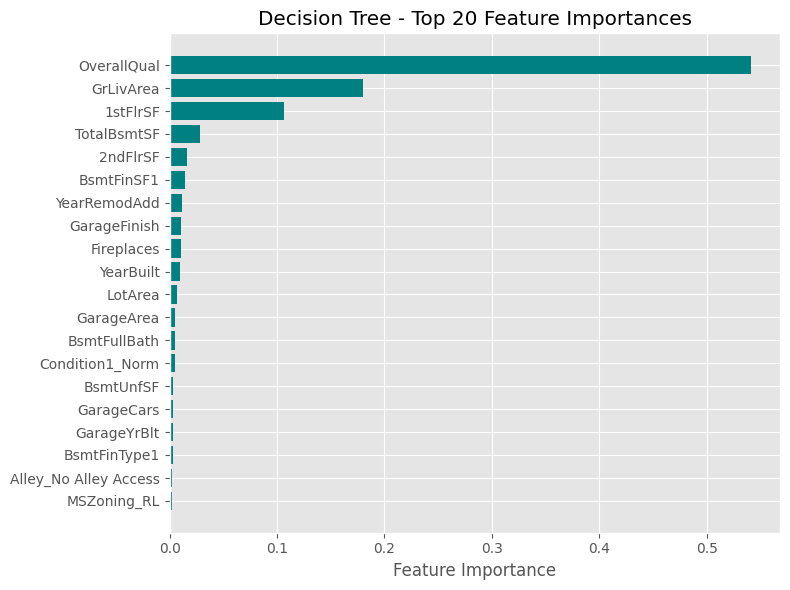

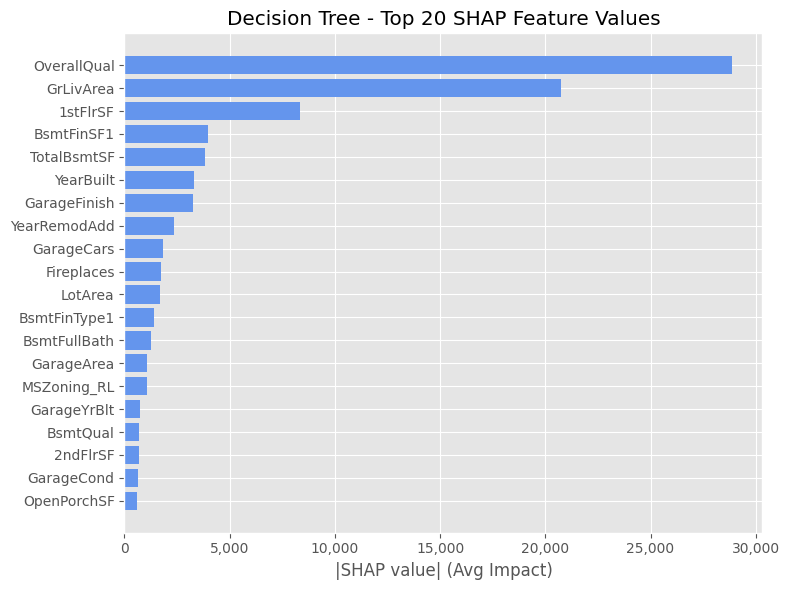

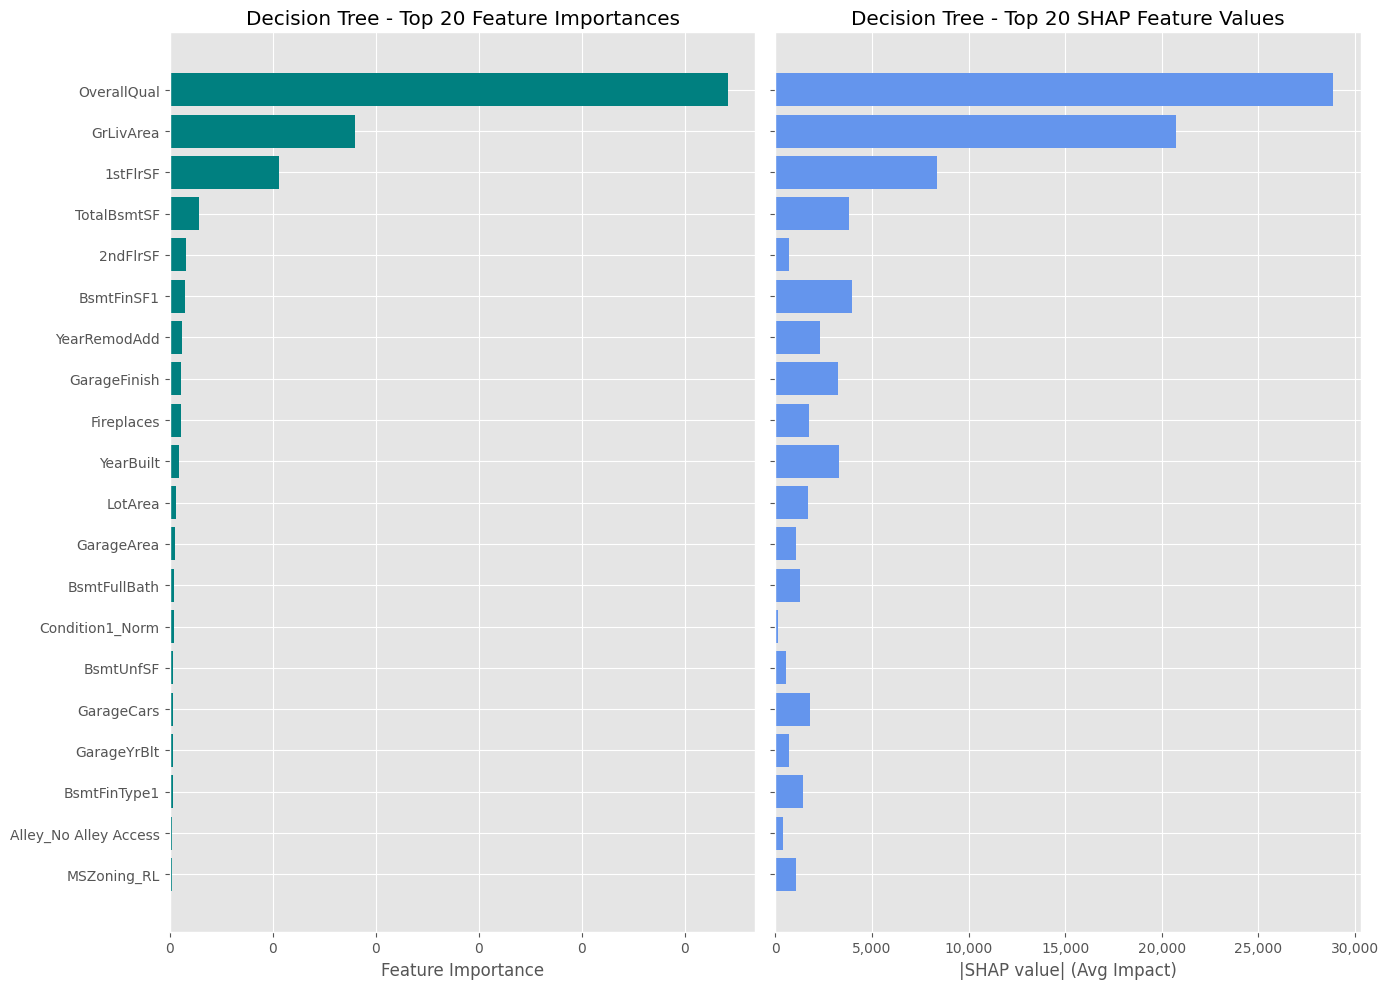

,Feature,Importance,|SHAP value|
198,OverallQual,0.5413,"28,876"
100,GrLivArea,0.1799,"20,759"
0,1stFlrSF,0.1064,"8,356"
235,TotalBsmtSF,0.0287,"3,826"
1,2ndFlrSF,0.0158,695
14,BsmtFinSF1,0.0147,"3,951"
239,YearRemodAdd,0.0118,"2,339"
90,GarageFinish,0.0109,"3,253"
78,Fireplaces,0.0108,"1,736"
238,YearBuilt,0.0095,"3,291"


In [90]:
#Decision Tree Regressor Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(grid_search_tree, 'Decision Tree')

In [65]:
bag_basic = cross_val_score(BaggingRegressor(random_state=2), X, Y, cv=5, scoring='r2')
print('Bagging Base Model Score:', float(bag_basic.mean()))

Bagging Base Model Score: 0.881530875341394


In [66]:
base_tree = DecisionTreeRegressor(random_state=2)
bagging_model = BaggingRegressor(estimator=base_tree, random_state=2, n_jobs=-1)

In [68]:
#Initial Bagging RandomizedSearchCV for faster estimates
bagging_param = {
    'estimator__criterion': ['squared_error'],
    'estimator__max_depth': [21, 22, 23],
    'n_estimators': [75, 76, 77]
}
random_search_bag = RandomizedSearchCV(
    bagging_model,
    param_distributions=bagging_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_bag.fit(X, Y)
print('Best parameters:', random_search_bag.best_params_)
print(f'Best CV Score: {random_search_bag.best_score_:.4f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'n_estimators': 76, 'estimator__max_depth': 22, 'estimator__criterion': 'squared_error'}
Best CV Score: 0.8960


In [69]:
#Final Bagging Grid Search
grid_params_bagging = {
    'estimator__criterion': ['squared_error'],
    'estimator__max_depth': [21, 22, 23],
    'n_estimators': [70, 71, 72]
}
grid_search_bagging = GridSearchCV(
    estimator=bagging_model,
    param_grid=grid_params_bagging,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_bagging.fit(X, Y)

print('Best parameters:', grid_search_bagging.best_params_)
print(f'Best CV Score: {grid_search_bagging.best_score_:.4f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 22, 'n_estimators': 71}
Best CV Score: 0.8959


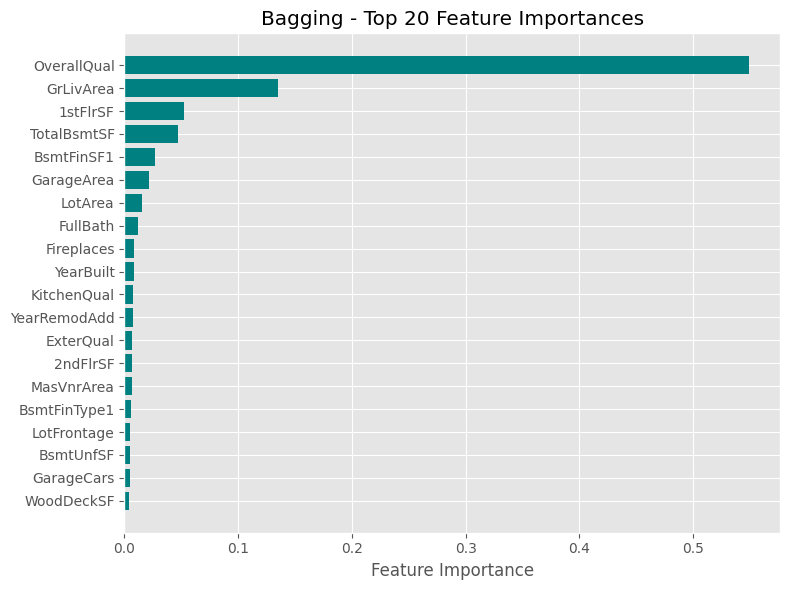

PermutationExplainer explainer: 2580it [26:28,  1.62it/s]                                                              


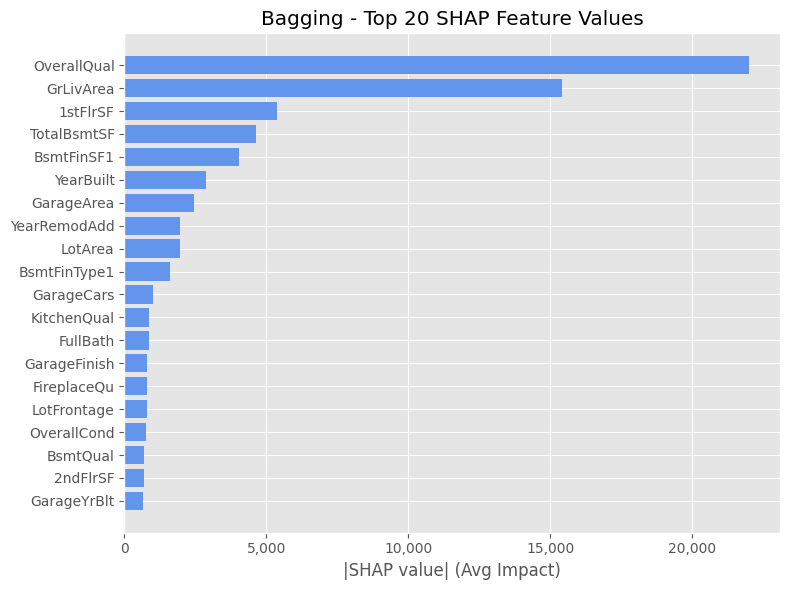

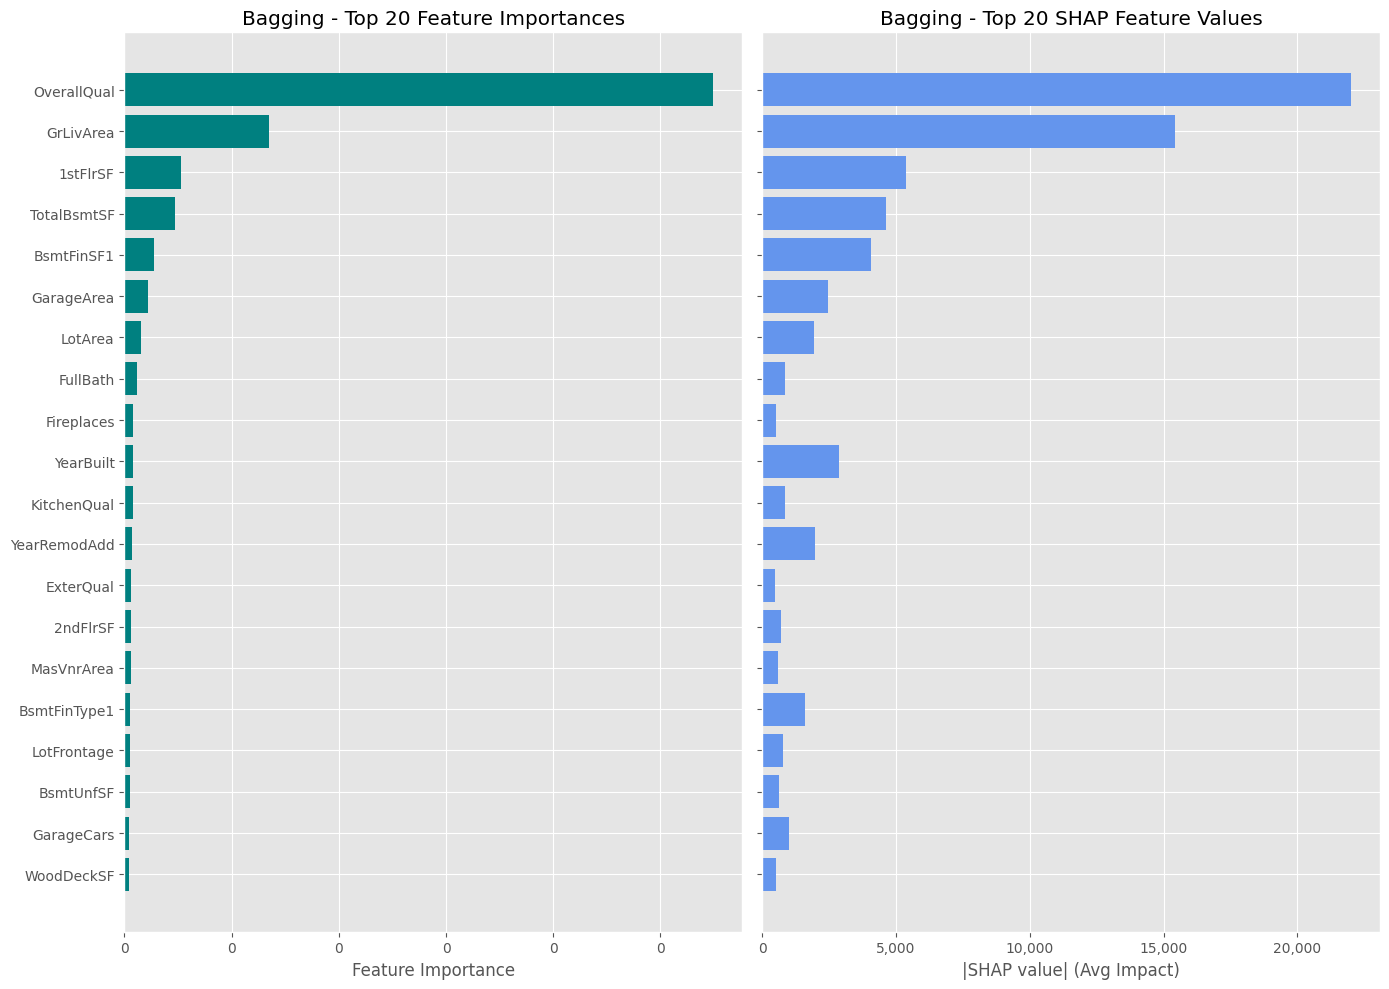

,Feature,Importance,|SHAP value|
198,OverallQual,0.5490,"21,987"
100,GrLivArea,0.1349,"15,425"
0,1stFlrSF,0.0525,"5,358"
235,TotalBsmtSF,0.0475,"4,615"
14,BsmtFinSF1,0.0272,"4,050"
87,GarageArea,0.0216,"2,459"
124,LotArea,0.0155,"1,949"
85,FullBath,0.0121,850
78,Fireplaces,0.0082,531
238,YearBuilt,0.0080,"2,867"


In [91]:
#Bagging Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_bag, 'Bagging')

In [92]:
#Base Random Forest Model 
rf_model = RandomForestRegressor(random_state=2, n_jobs=-1)
rf_model.fit(X, Y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
print('Random Forest Base Model Score:', float(cross_val_score(rf_model, X, Y).mean()))

0.8951755258558339

In [93]:
#Initial Random Forest RandomizedSearchCV for faster estimates
rf_param = {
    'criterion': ['friedman_mse'],
    'max_depth': range(21, 27),
    'n_estimators': range(156, 224),
    'max_features': ['sqrt']
}
random_search_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_rf.fit(X, Y)
print('Best parameters:', random_search_rf.best_params_)
print(f'Best CV Score: {random_search_rf.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_estimators': 213, 'max_features': 'sqrt', 'max_depth': 24, 'criterion': 'friedman_mse'}
Best CV Score: 0.8962


In [29]:
#Final Random Forest Grid Search
rf_param = {
    'criterion': ['friedman_mse'],
    'max_depth': range(21, 28),
    'n_estimators': range(180, 205),
    'max_features': ['sqrt']
}
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X, Y)
print('Best parameters:', grid_search_rf.best_params_)
print(f'Best CV Score: {grid_search_rf.best_score_:.4f}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 24, 'max_features': 'sqrt', 'n_estimators': 192}
Best CV Score: 0.8966


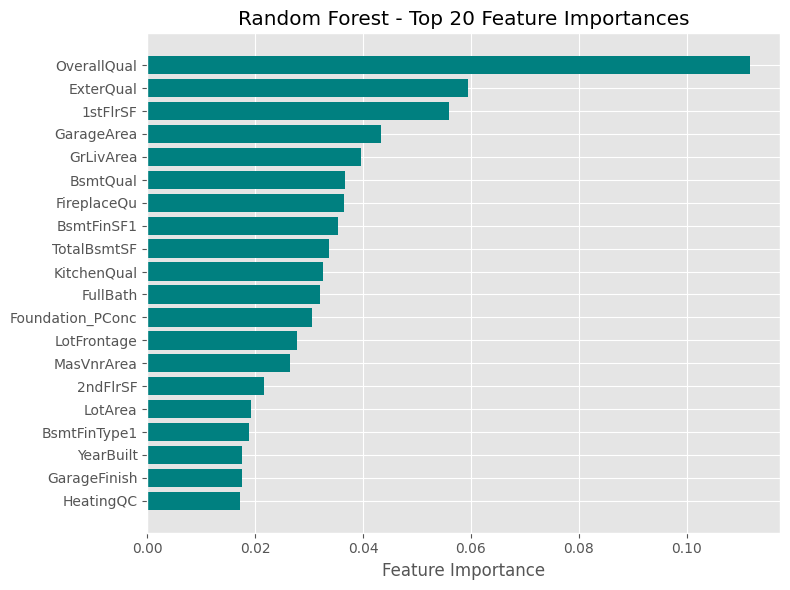

PermutationExplainer explainer: 2580it [06:05,  6.86it/s]                                                              


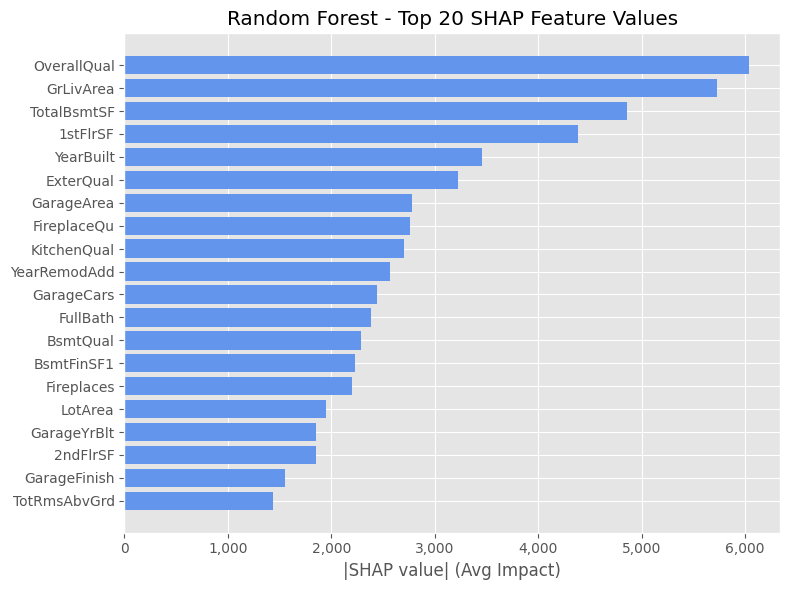

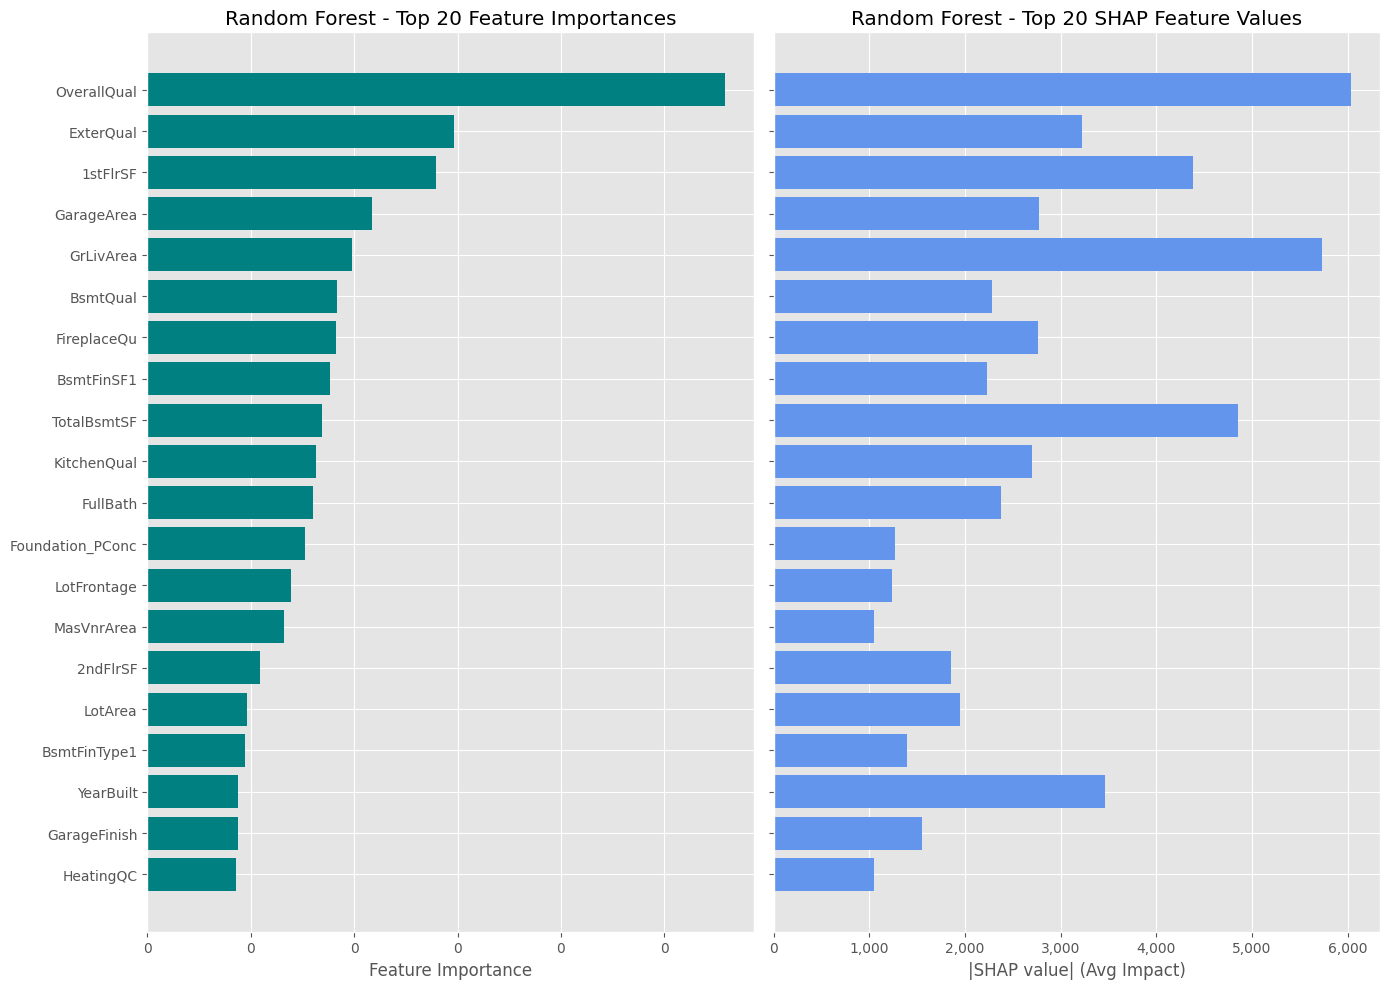

,Feature,Importance,|SHAP value|
198,OverallQual,0.1117,"6,037"
44,ExterQual,0.0594,"3,224"
0,1stFlrSF,0.0559,"4,383"
87,GarageArea,0.0434,"2,777"
100,GrLivArea,0.0396,"5,733"
20,BsmtQual,0.0366,"2,283"
77,FireplaceQu,0.0365,"2,761"
14,BsmtFinSF1,0.0354,"2,227"
235,TotalBsmtSF,0.0337,"4,859"
118,KitchenQual,0.0326,"2,705"


In [95]:
#Random Forest Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_rf, 'Random Forest')

In [96]:
#Gradient Boosting
gbm = GradientBoostingRegressor(random_state=2, verbose=1)
gbm.fit(X, Y)

      Iter       Train Loss   Remaining Time 
         1  4844443779.7734            1.55s
         2  4186475306.2411            1.33s
         3  3647244417.1483            1.23s
         4  3195085263.6057            1.16s
         5  2806968198.0603            1.12s
         6  2488502032.9832            1.08s
         7  2211406942.9509            1.05s
         8  1979081595.9975            1.03s
         9  1769485791.0540            1.04s
        10  1586705403.9391            1.01s
        20   709796683.5749            0.87s
        30   451529330.0990            0.76s
        40   346356827.7832            0.64s
        50   295046008.7429            0.53s
        60   262640066.6024            0.42s
        70   239821746.4581            0.32s
        80   221500863.6241            0.21s
        90   207386436.6705            0.11s
       100   196483824.0830            0.00s


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [32]:
print('GradientBoosting Base Model Score:', float(cross_val_score(gbm, X, Y).mean()))

      Iter       Train Loss   Remaining Time 
         1  4541205303.3751            2.31s
         2  3925329347.9286            2.77s
         3  3407690380.5198            2.48s
         4  2973081126.3941            2.33s
         5  2605556518.4339            2.23s
         6  2303283596.7830            2.13s
         7  2044582357.1434            2.06s
         8  1813887944.0161            2.02s
         9  1612351749.8694            1.99s
        10  1453410013.0922            1.91s
        20   612024530.5015            1.60s
        30   374431730.8410            1.27s
        40   285678745.0720            1.11s
        50   242743961.9985            0.94s
        60   214289684.4926            0.74s
        70   195273222.5784            0.56s
        80   180626758.4808            0.37s
        90   168606209.2128            0.18s
       100   157237445.1394            0.00s
      Iter       Train Loss   Remaining Time 
         1  4572328385.6264            1.35s
        

In [98]:
#Initial Gradient Boosting RandomizedSearchCV for faster estimates
gbm_param = {
    'learning_rate': [.03, .04],
    'subsample': [.1, .2, .3, .4],
    'max_depth': range(25, 29),
    'n_estimators': range(170, 195),
    'criterion': ['friedman_mse'],
    'max_features': ['sqrt']
}
random_search_gbm = RandomizedSearchCV(
    estimator=gbm,
    param_distributions=gbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_gbm.fit(X, Y)
print('Best parameters:', random_search_gbm.best_params_)
print(f'Best CV Score: {random_search_gbm.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1  6213813867.7452   249147279.4664            0.59s
         2  5471706076.0295    61675500.2889            0.51s
         3  4496342502.3873   -67811377.8065            0.47s
         4  4236804137.9424   226051780.4269            0.45s
         5  4251862587.4322   346282611.9500            0.44s
         6  4297671381.3022   336289785.0999            0.43s
         7  3861536508.8806   113098291.6545            0.42s
         8  3730182175.8372   222456869.8101            0.43s
         9  3511353907.0859   179906179.7395            0.42s
        10  3346165176.3253   172772593.8251            0.41s
        20  2076856083.1882   146976890.5759            0.38s
        30  1397477937.2769   189567590.8160            0.37s
        40   811810393.5852    48432513.1310            0.34s
        50   608731356.7987    99182948.8990            0.31s
       

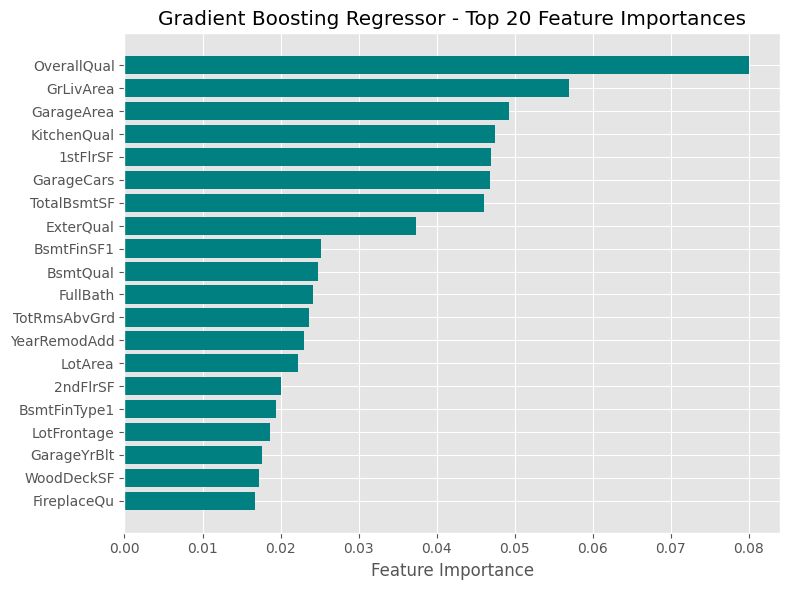

PermutationExplainer explainer: 2580it [07:32,  5.57it/s]                                                              


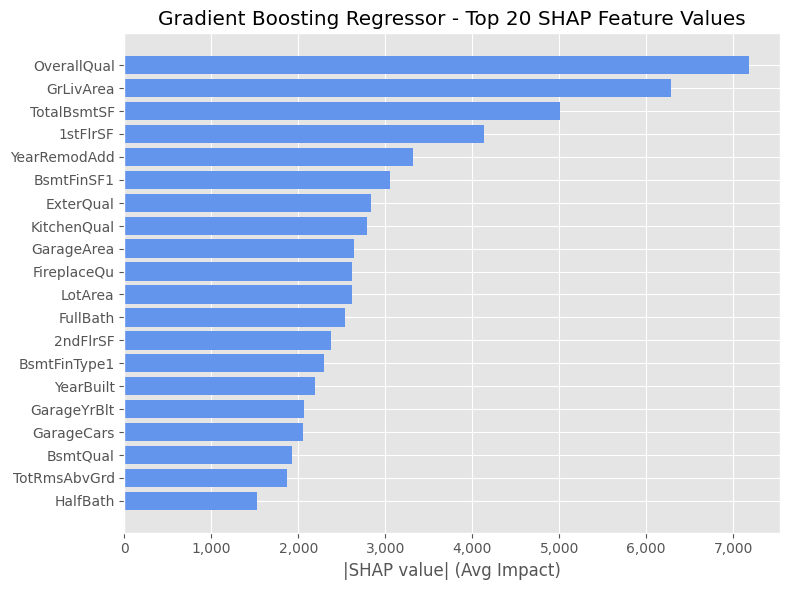

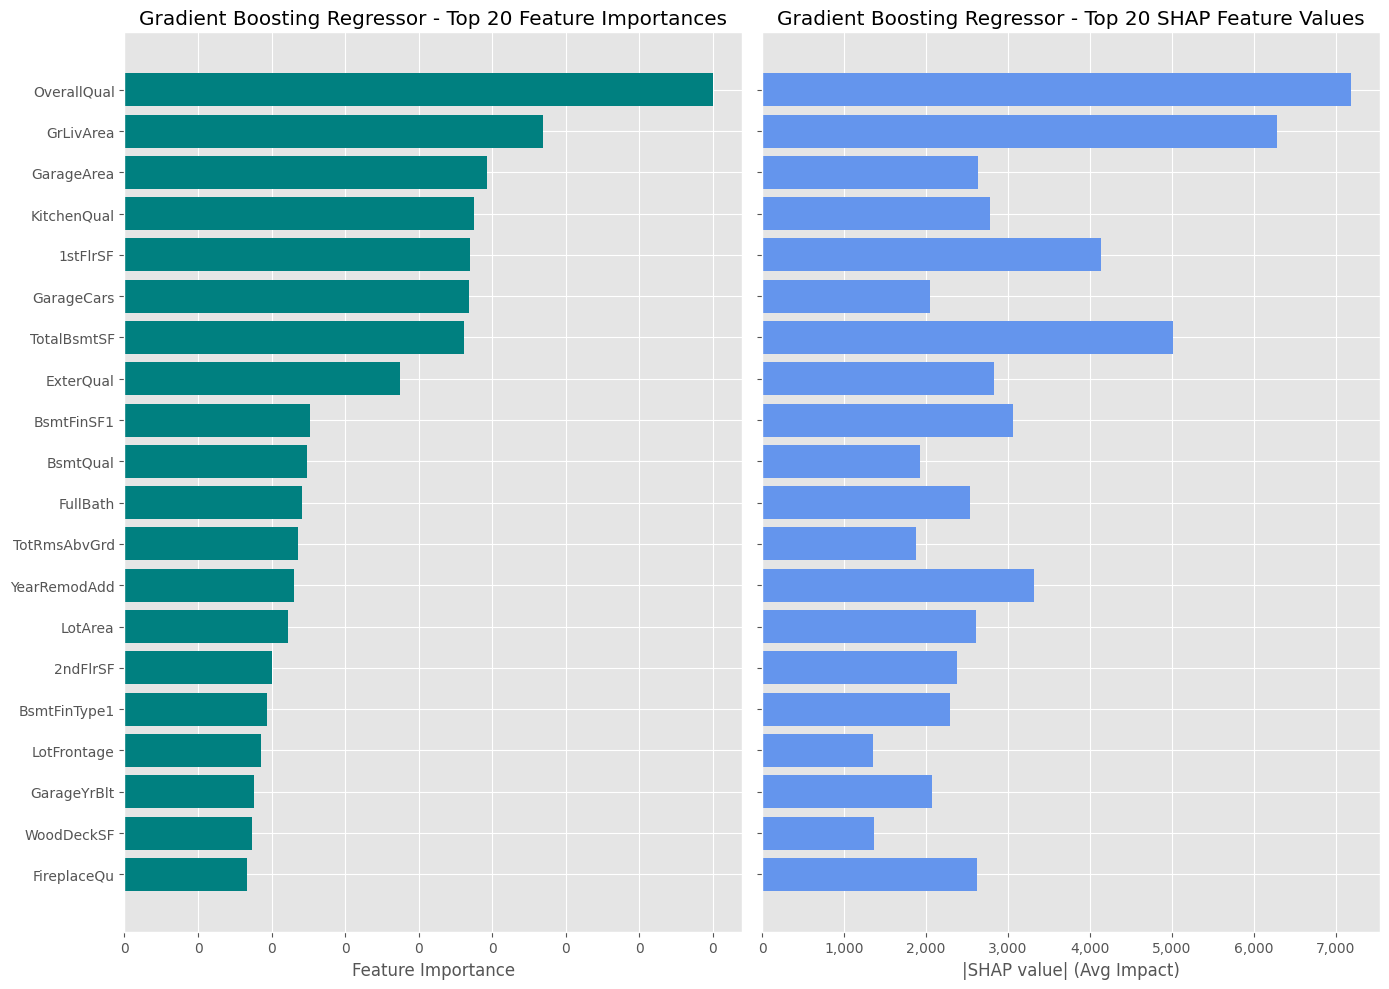

,Feature,Importance,|SHAP value|
198,OverallQual,0.0800,"7,179"
100,GrLivArea,0.0569,"6,283"
87,GarageArea,0.0493,"2,635"
118,KitchenQual,0.0475,"2,784"
0,1stFlrSF,0.0470,"4,130"
88,GarageCars,0.0469,"2,049"
235,TotalBsmtSF,0.0461,"5,012"
44,ExterQual,0.0374,"2,829"
14,BsmtFinSF1,0.0252,"3,056"
20,BsmtQual,0.0248,"1,930"


In [99]:
#Gradient Boosting Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_gbm, 'Gradient Boosting Regressor')

In [9]:
#Hist Gradient Boosting Base Model
hgbm = HistGradientBoostingRegressor(random_state=2, verbose=1)
hgbm.fit(X, Y)

Binning 0.005 GB of training data: 0.051 s
Fitting gradient boosted rounds:
Fit 100 trees in 4.904 s, (3100 total leaves)
Time spent computing histograms: 0.839s
Time spent finding best splits:  0.080s
Time spent applying splits:      0.054s
Time spent predicting:           0.003s


,loss,'squared_error'
,quantile,None
,learning_rate,0.1
,max_iter,100
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


In [9]:
print('HistGradientBoosting Base Model Score:', float(cross_val_score(hgbm, X, Y).mean()))

Binning 0.004 GB of training data: 0.068 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.363 s, (3100 total leaves)
Time spent computing histograms: 0.809s
Time spent finding best splits:  0.078s
Time spent applying splits:      0.058s
Time spent predicting:           0.003s
Binning 0.004 GB of training data: 0.055 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.258 s, (3100 total leaves)
Time spent computing histograms: 0.745s
Time spent finding best splits:  0.076s
Time spent applying splits:      0.056s
Time spent predicting:           0.004s
Binning 0.004 GB of training data: 0.054 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.252 s, (3100 total leaves)
Time spent computing histograms: 0.753s
Time spent finding best splits:  0.071s
Time spent applying splits:      0.053s
Time spent predicting:           0.003s
Binning 0.004 GB of training data: 0.052 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.284 s, (3100 total leaves)
Time spent computing histograms:

0.9121093445438377

In [11]:
#Initial Hist Gradient Boosting RandomizedSearchCV for faster estimates
hgbm_param = {
    'learning_rate': [0.06402125, 0.0644, 0.06477875],
    'max_leaf_nodes': [10],
    'max_iter': [224],
    'min_samples_leaf': [15],
    #'l2_regularization': [0.0, 0.1, 0.5, 1.0],
}
random_search_hgb = RandomizedSearchCV(
    estimator=hgbm,
    param_distributions=hgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_hgb.fit(X, Y)
print('Best parameters:', random_search_hgb.best_params_)
print(f'Best CV Score: {random_search_hgb.best_score_:.4f}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Binning 0.005 GB of training data: 0.048 s
Fitting gradient boosted rounds:
Fit 224 trees in 1.062 s, (2240 total leaves)
Time spent computing histograms: 0.678s
Time spent finding best splits:  0.075s
Time spent applying splits:      0.037s
Time spent predicting:           0.005s
Best parameters: {'min_samples_leaf': 15, 'max_leaf_nodes': 10, 'max_iter': 224, 'learning_rate': 0.06402125}
Best CV Score: 0.9213


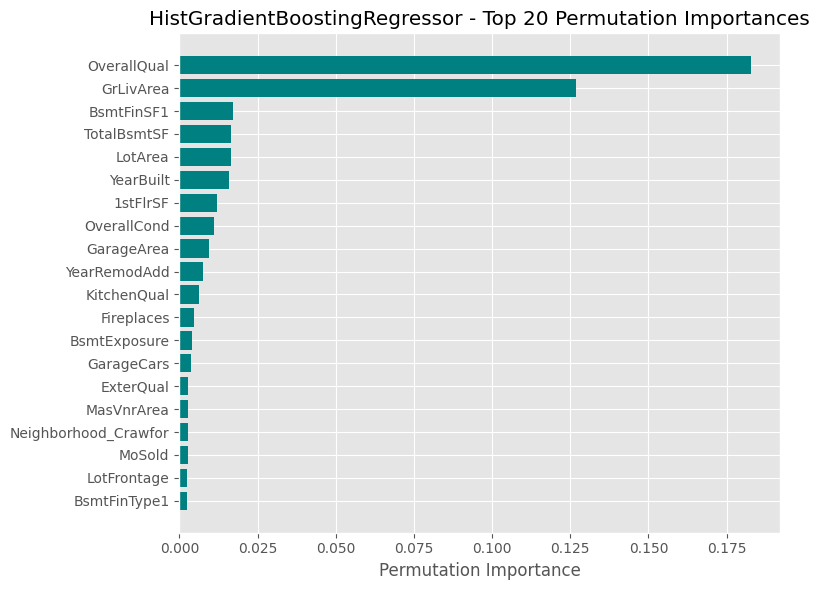

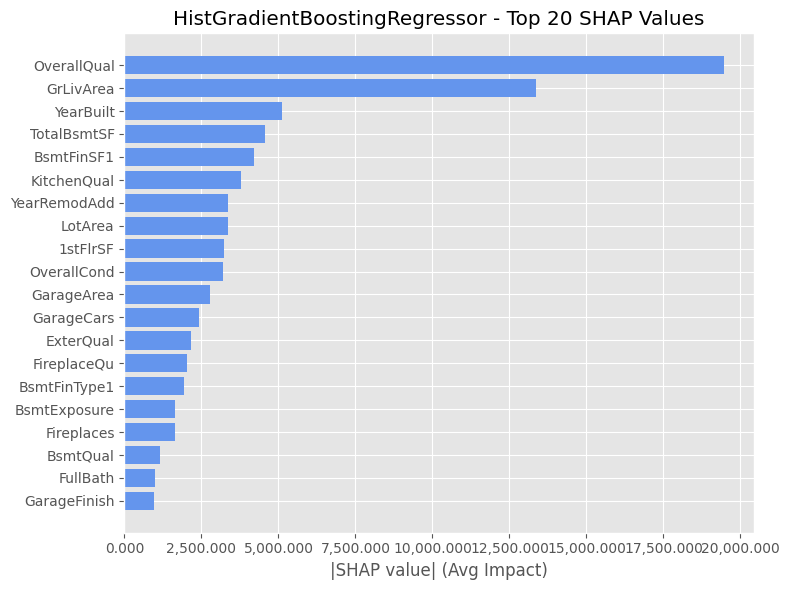

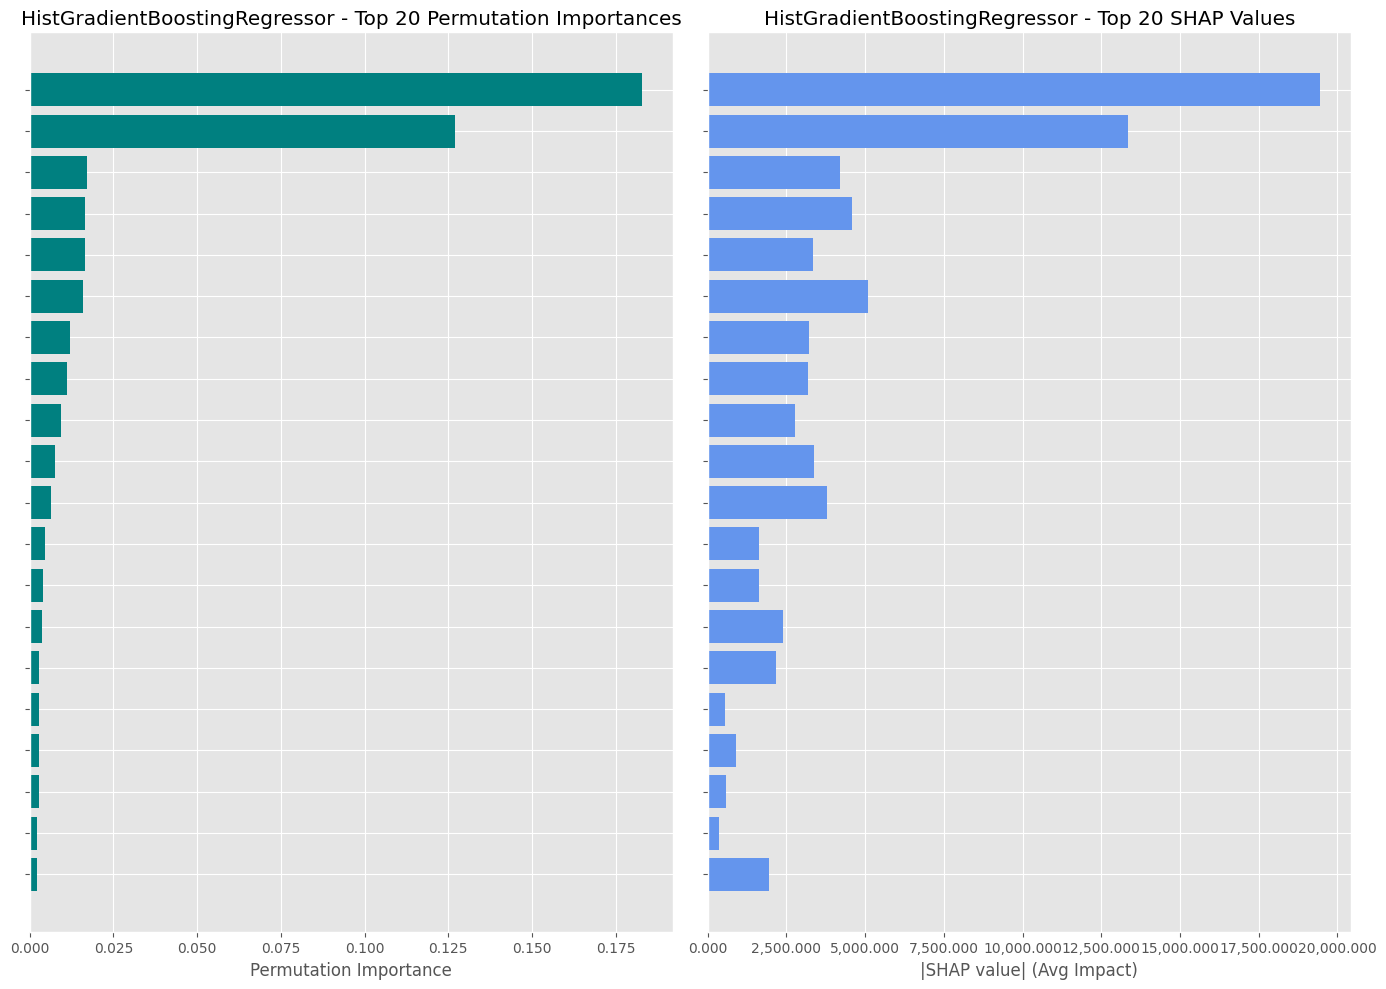

,Feature,Importance,|SHAP value|
198,OverallQual,0.1829,"19,453"
100,GrLivArea,0.1269,"13,362"
14,BsmtFinSF1,0.0171,"4,197"
235,TotalBsmtSF,0.0165,"4,577"
124,LotArea,0.0164,"3,359"
238,YearBuilt,0.0158,"5,104"
0,1stFlrSF,0.0119,"3,217"
197,OverallCond,0.0110,"3,191"
87,GarageArea,0.0094,"2,774"
239,YearRemodAdd,0.0074,"3,364"


In [12]:
#Hist Gradient Boosting Regressor Feature Importances & SHAP values
Plot_HGB_Feature_SHAP_Importances(random_search_hgb)

In [103]:
#Base XGBoost Model
xgbm = XGBRegressor(random_state=2, n_jobs=-1, verbosity=1, booster='gbtree')
xgbm.fit(X, Y)

,objective,'reg:squarederror'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [23]:
print('XGBoost Base Model Score:', float(cross_val_score(xgbm, X, Y).mean()))

XGBoost Base Model Score: 0.8996396422386169


In [106]:
#Initial XGBoost RandomizedSearchCV for faster estimates
xgbm_param = {
    'learning_rate': np.linspace(0.01, 0.1, 11),
    'subsample': np.linspace(0.7, 1, 4),
    'colsample_bytree': np.linspace(0.7, 1, 4),
    'max_depth': range(2, 11),
    'n_estimators': range(210, 260),
    'min_child_weight': range(1, 11),
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': np.linspace(0, 1, 5),
    'reg_alpha': np.linspace(0, 1, 5),
}
random_search_xgbm = RandomizedSearchCV(
    estimator=xgbm,
    param_distributions=xgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_xgbm.fit(X, Y)
print('Best parameters:', random_search_xgbm.best_params_)
print(f'Best CV Score: {random_search_xgbm.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': np.float64(0.7999999999999999), 'reg_lambda': np.float64(1.0), 'reg_alpha': np.float64(0.25), 'n_estimators': 244, 'min_child_weight': 9, 'max_depth': 4, 'learning_rate': np.float64(0.1), 'gamma': 0.2, 'colsample_bytree': np.float64(0.9)}
Best CV Score: 0.9208


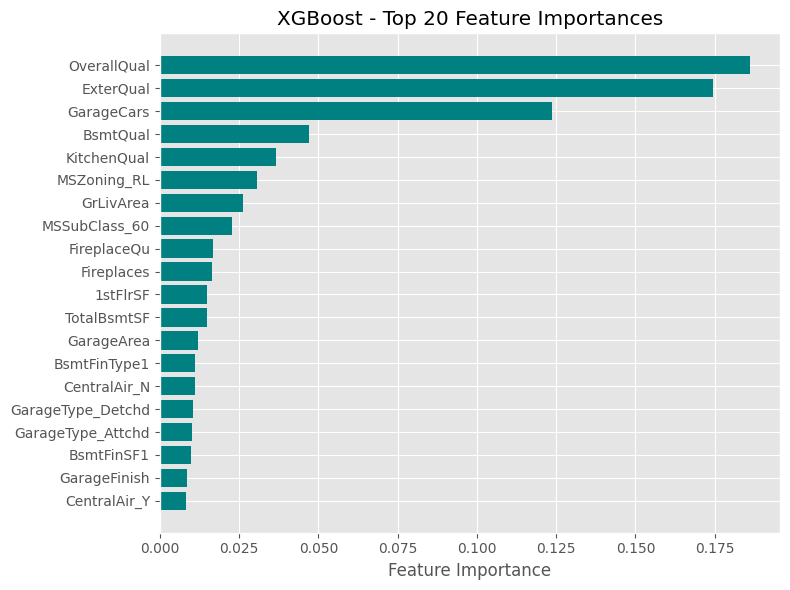

PermutationExplainer explainer: 2580it [03:22, 12.10it/s]                                                              


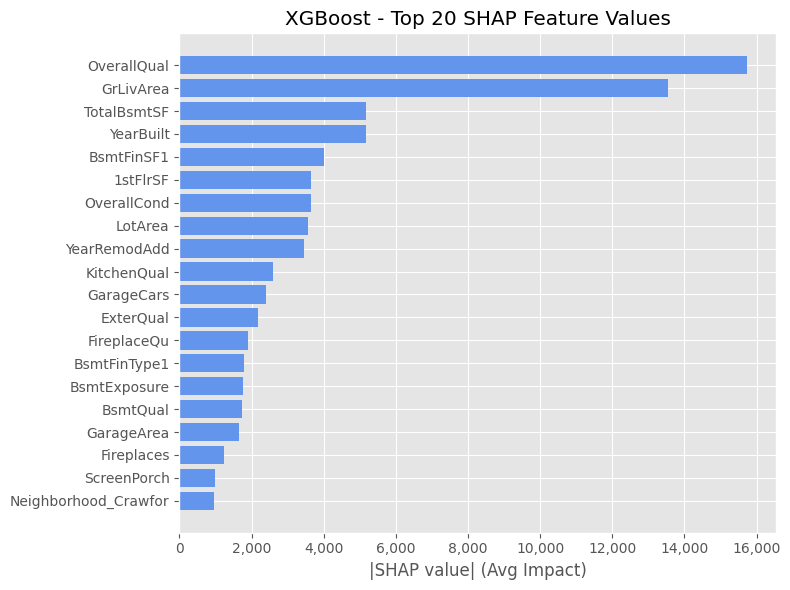

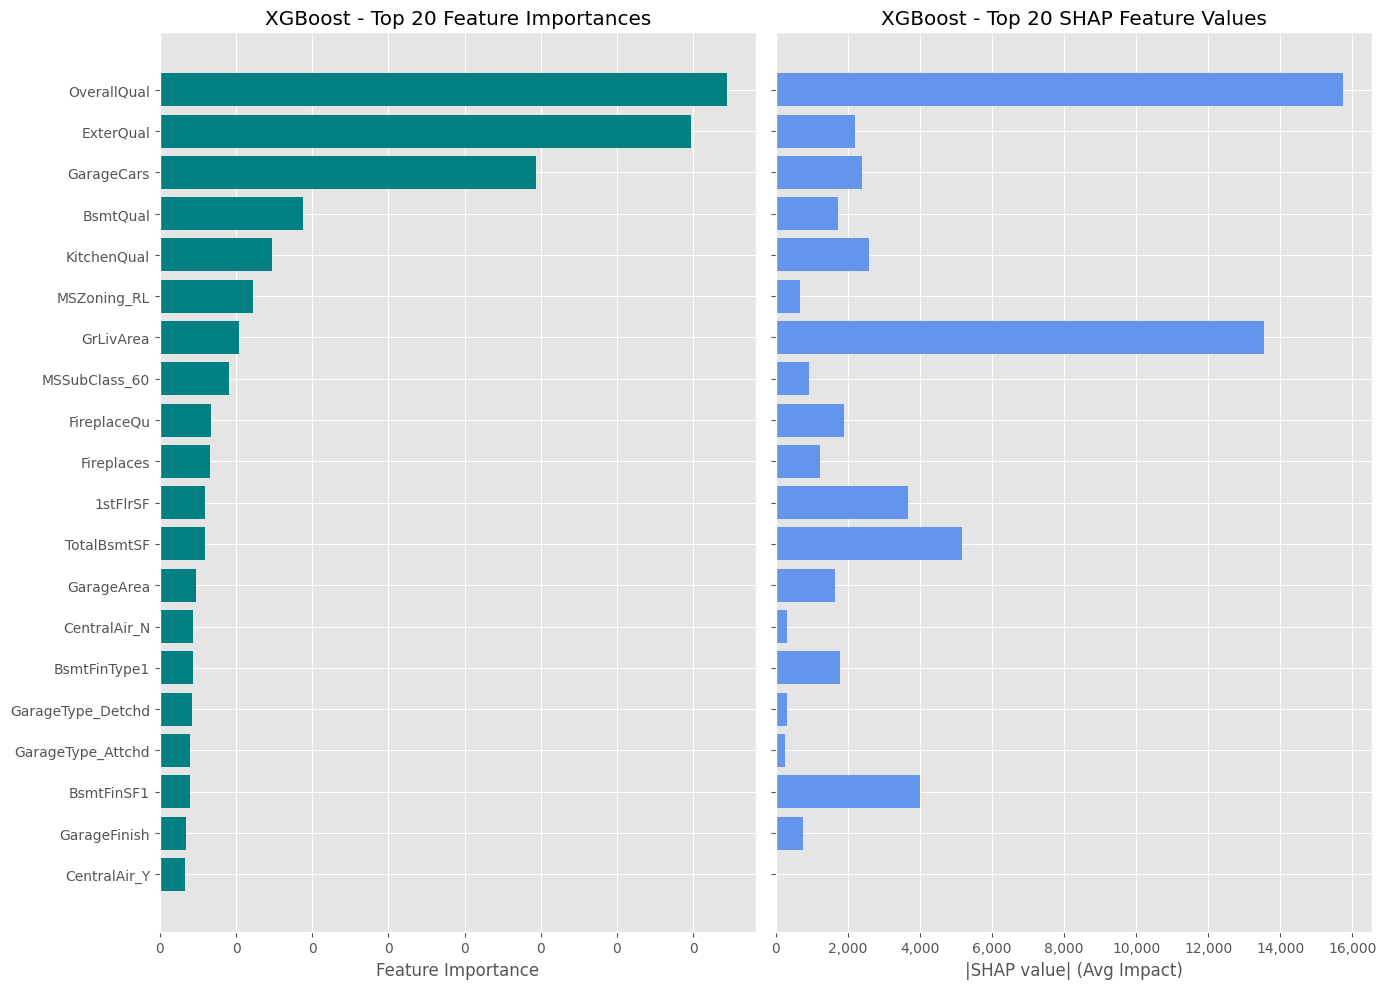

,Feature,Importance,|SHAP value|
198,OverallQual,0.1863,"15,747"
44,ExterQual,0.1744,"2,194"
88,GarageCars,0.1236,"2,397"
20,BsmtQual,0.0470,"1,729"
118,KitchenQual,0.0367,"2,584"
154,MSZoning_RL,0.0307,679
100,GrLivArea,0.0261,"13,539"
143,MSSubClass_60,0.0228,919
77,FireplaceQu,0.0167,"1,908"
78,Fireplaces,0.0165,"1,240"


In [107]:
#XGBoost Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_xgbm, 'XGBoost')

In [108]:
#Base LightGBM Model
lgbm = LGBMRegressor(random_state=2, verbose=1, n_jobs=-1)
lgbm.fit(X, Y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3939
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 173
[LightGBM] [Info] Start training from score 178053.442420


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [25]:
print('LightGBM Base Model Score:', float(cross_val_score(lgbm, X, Y).mean()))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3839
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 165
[LightGBM] [Info] Start training from score 177061.364033
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3851
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 164
[LightGBM] [Info] Start training from score 177182.857974
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

In [110]:
#Initial LightGBM RandomizedSearchCV for faster estimates
lgbm_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30],
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [1, 50, 99],
    'n_estimators': range(150, 250),
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5]
}
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_lgbm.fit(X, Y)
print('Best parameters:', random_search_lgbm.best_params_)
print(f'Best CV Score: {random_search_lgbm.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3939
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 173
[LightGBM] [Info] Start training from score 178053.442420
Best parameters: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'num_leaves': 15, 'n_estimators': 165, 'min_child_samples': 20, 'max_depth': 50, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best CV Score: 0.9182


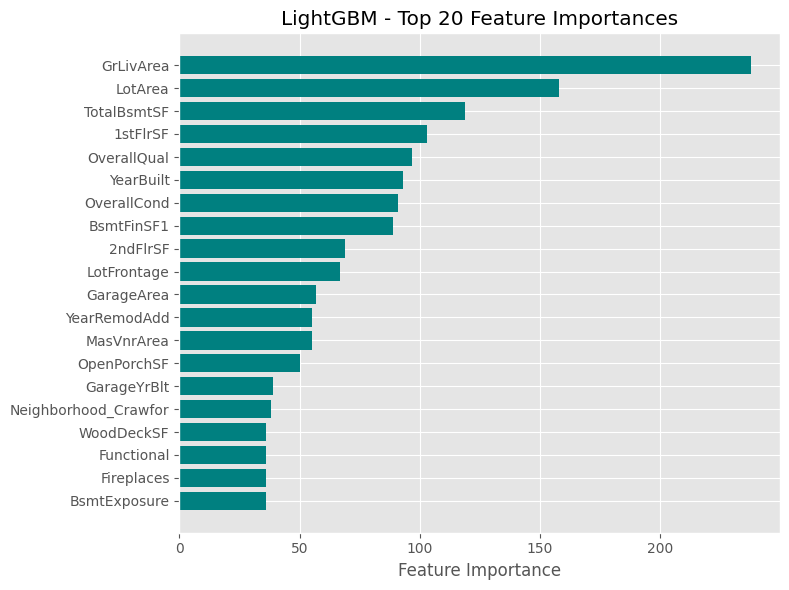

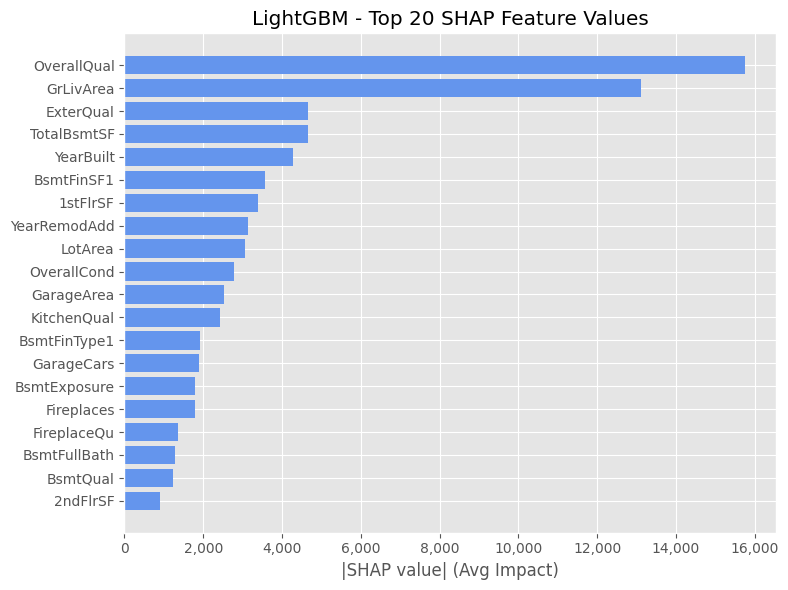

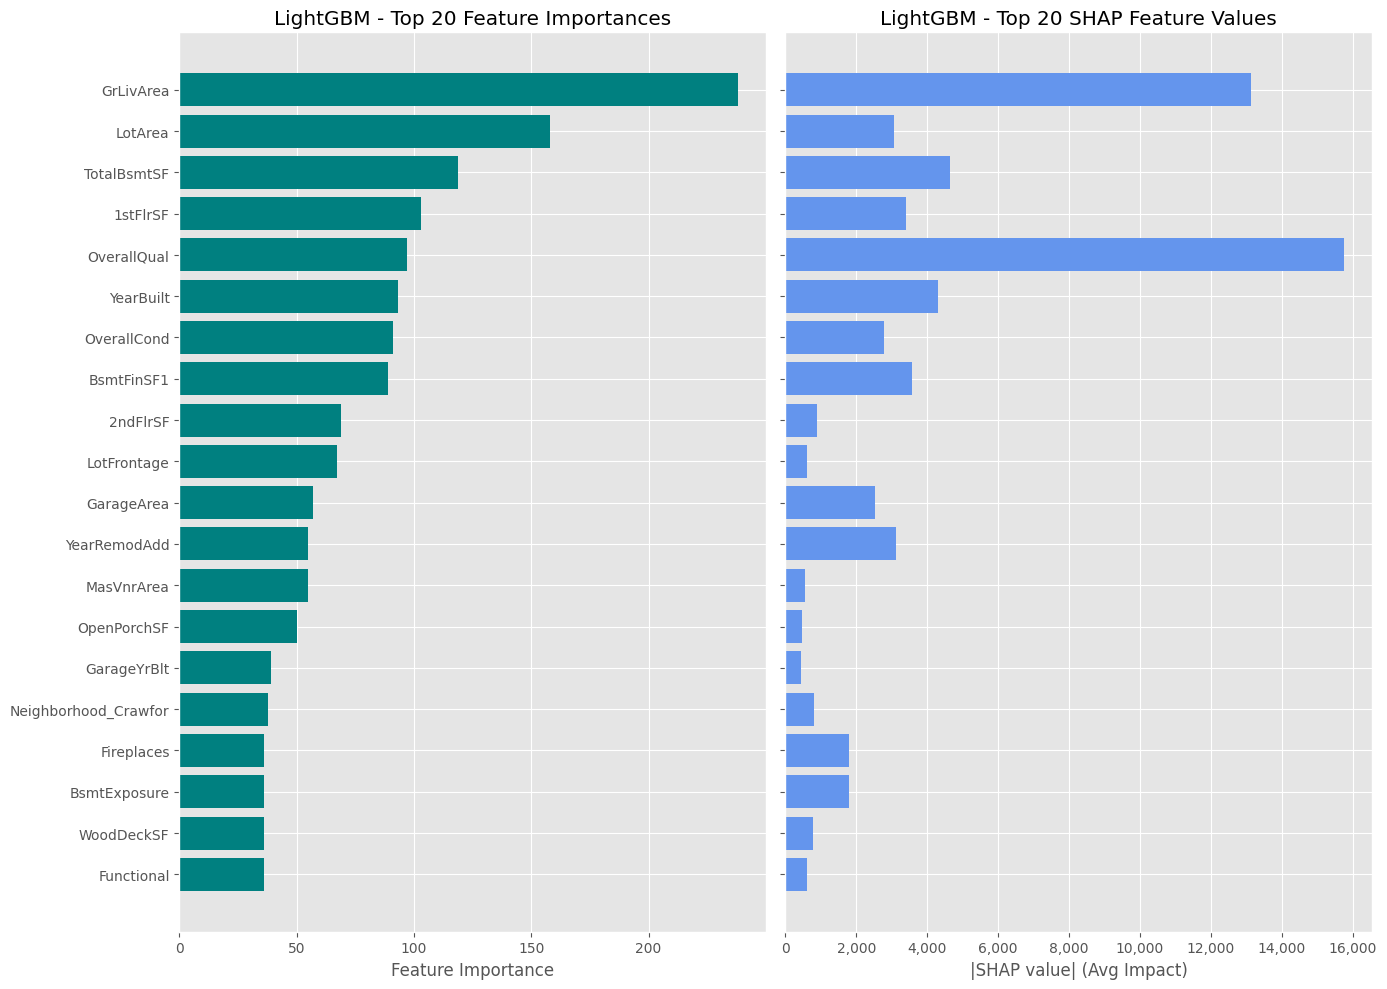

,Feature,Importance,|SHAP value|
100,GrLivArea,238.0000,"13,117"
124,LotArea,158.0000,"3,071"
235,TotalBsmtSF,119.0000,"4,648"
0,1stFlrSF,103.0000,"3,398"
198,OverallQual,97.0000,"15,744"
238,YearBuilt,93.0000,"4,289"
197,OverallCond,91.0000,"2,769"
14,BsmtFinSF1,89.0000,"3,566"
1,2ndFlrSF,69.0000,904
130,LotFrontage,67.0000,602


In [111]:
#LightGBM Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_lgbm, 'LightGBM')

In [112]:
#Base CatBoost Model
cat_boost = CatBoostRegressor(random_state=2, verbose=0, thread_count=-1)
cat_boost.fit(X, Y)

In [27]:
print('CatBoost Base Model Score:', float(cross_val_score(cat_boost, X, Y).mean()))

CatBoost Base Model Score: 0.9295837490188994


In [114]:
#Initial CatBoost RandomizedSearchCV for faster estimates
cat_boost_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0],
    'min_data_in_leaf': [10, 20, 30],
    'depth': [4, 6, 8, 10],
    'iterations': range(150, 250),
    'l2_leaf_reg': [0.0, 0.1, 0.5, 1.0]
}
random_search_cat = RandomizedSearchCV(
    estimator=cat_boost,
    param_distributions=cat_boost_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_cat.fit(X, Y)
print('Best parameters:', random_search_cat.best_params_)
print(f'Best CV Score: {random_search_cat.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 0.7, 'min_data_in_leaf': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 0.0, 'iterations': 207, 'depth': 6, 'colsample_bylevel': 0.8}
Best CV Score: 0.9243


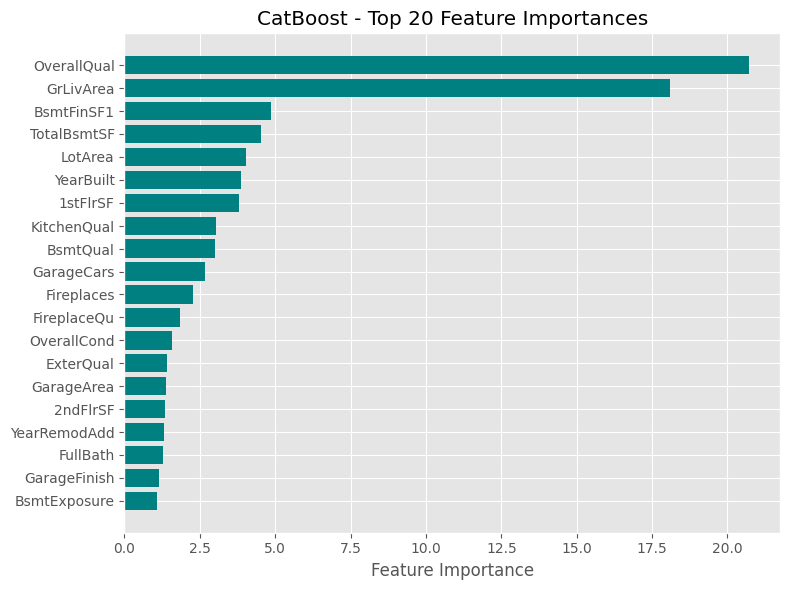

 99%|===================| 2560/2579 [00:44<00:00]        

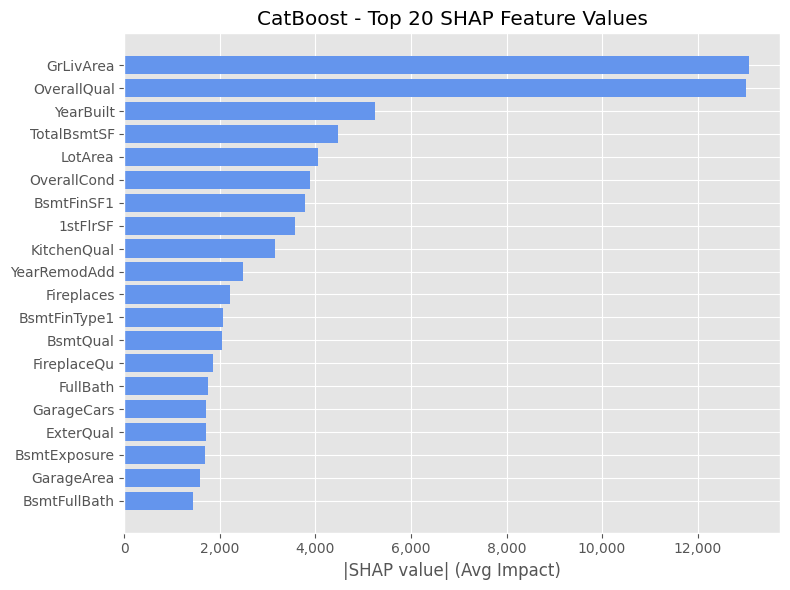

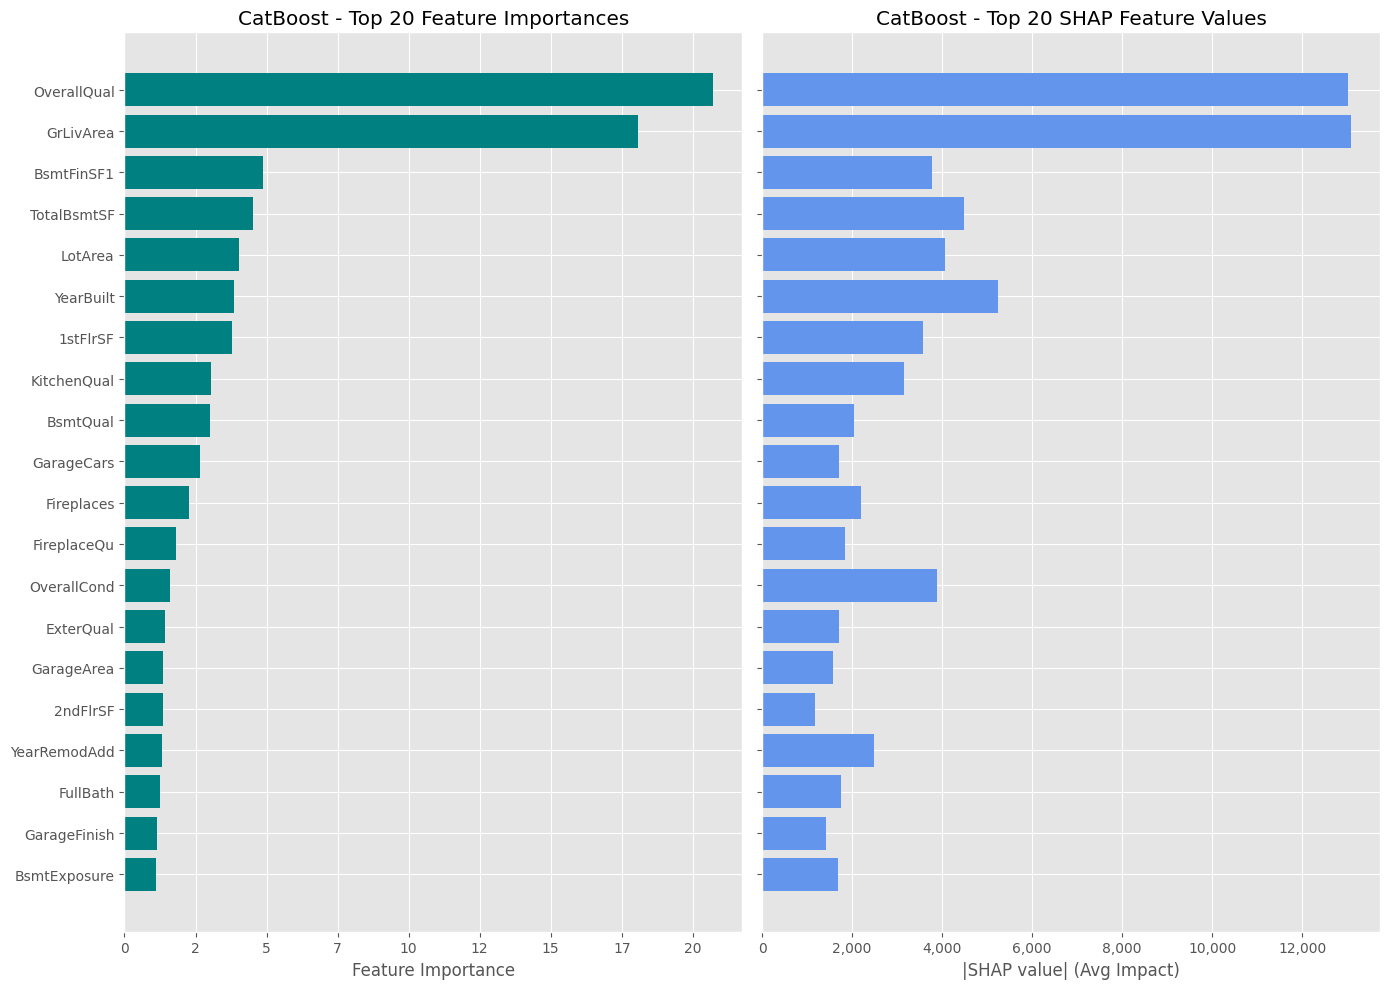

,Feature,Importance,|SHAP value|
198,OverallQual,20.7071,"13,013"
100,GrLivArea,18.0883,"13,073"
14,BsmtFinSF1,4.8632,"3,775"
235,TotalBsmtSF,4.5362,"4,474"
124,LotArea,4.0282,"4,051"
238,YearBuilt,3.8553,"5,236"
0,1stFlrSF,3.7978,"3,566"
118,KitchenQual,3.0312,"3,152"
20,BsmtQual,3.0189,"2,037"
88,GarageCars,2.6700,"1,709"


In [115]:
#CatBoost Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(cat_boost, 'CatBoost')

In [116]:
#Base AdaBoost Model
adaBoost = AdaBoostRegressor(estimator = tree_model, random_state=2)
adaBoost.fit(X, Y)

,estimator,DecisionTreeR...andom_state=2)
,n_estimators,50
,learning_rate,1.0
,loss,'linear'
,random_state,2
,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [29]:
print('AdaBoost Base Model Score:', float(cross_val_score(adaBoost, X, Y).mean()))

AdaBoost Base Model Score: 0.8990286922227536


In [61]:
#Initial AdaBoost RandomizedSearchCV for faster estimates
adaBoost_param = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7, 9, 11],
    'n_estimators': range(100, 250),
    'loss': ['linear', 'square', 'exponential']
}
random_search_adaBoost = RandomizedSearchCV(
    estimator=adaBoost,
    param_distributions=adaBoost_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_adaBoost.fit(X, Y)
print('Best parameters:', random_search_adaBoost.best_params_)
print(f'Best CV Score: {random_search_adaBoost.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_estimators': 184, 'loss': 'linear', 'learning_rate': 0.2, 'estimator__max_depth': 7}
Best CV Score: 0.8893


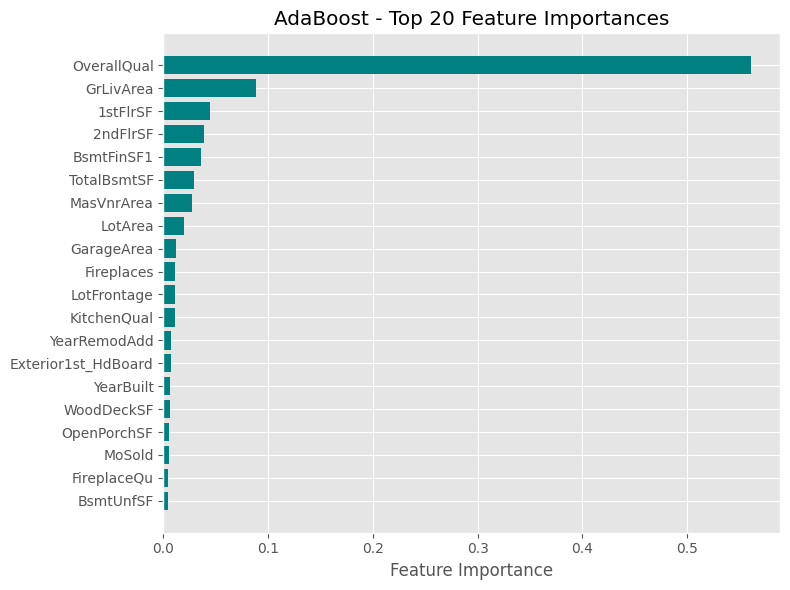

PermutationExplainer explainer: 2580it [16:30,  2.58it/s]                                                              


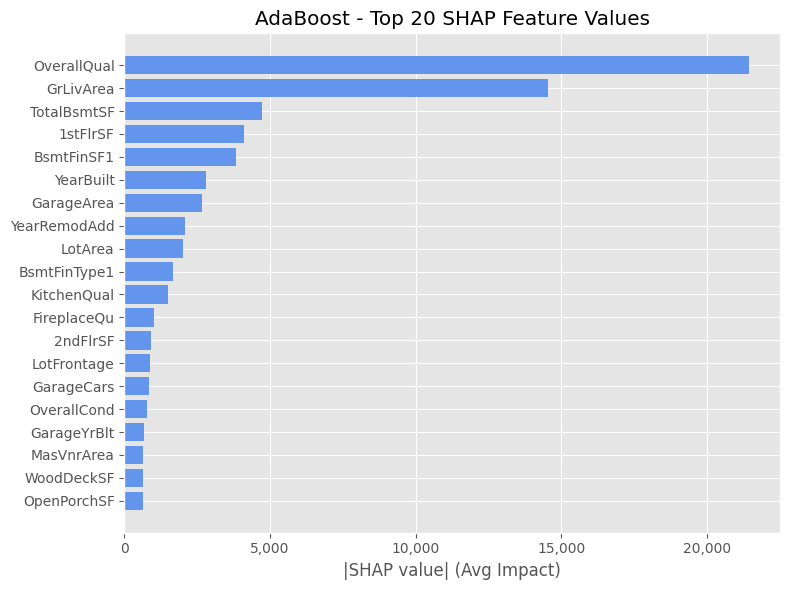

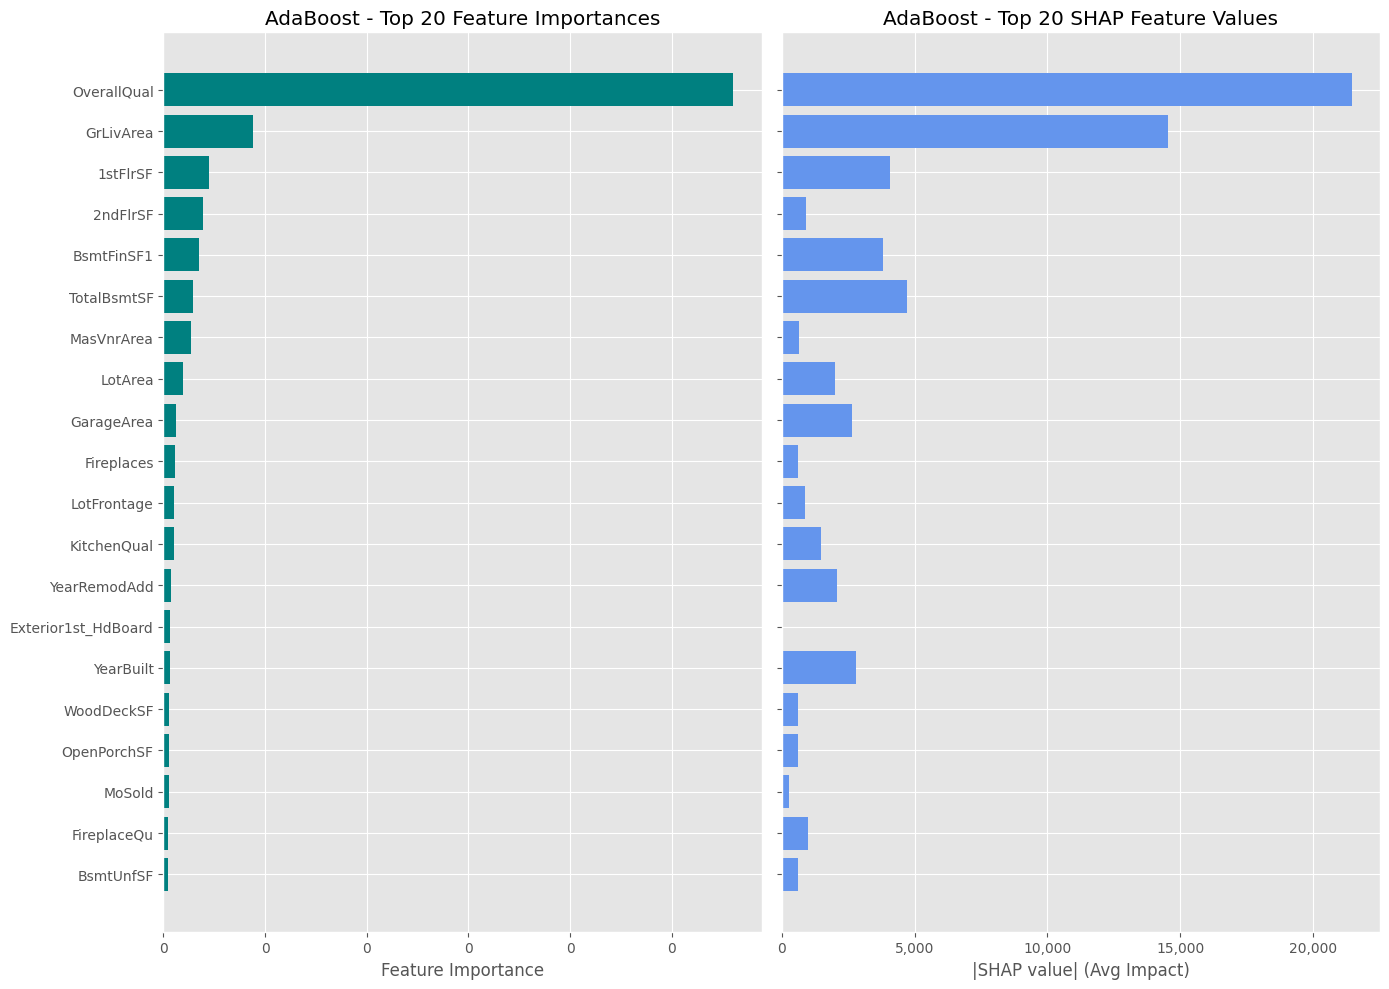

,Feature,Importance,|SHAP value|
198,OverallQual,0.5606,"21,446"
100,GrLivArea,0.0879,"14,558"
0,1stFlrSF,0.0448,"4,095"
1,2ndFlrSF,0.0390,915
14,BsmtFinSF1,0.0354,"3,826"
235,TotalBsmtSF,0.0293,"4,717"
156,MasVnrArea,0.0275,649
124,LotArea,0.0194,"2,006"
87,GarageArea,0.0121,"2,646"
78,Fireplaces,0.0114,604


In [117]:
#AdaBoost Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(adaBoost, 'AdaBoost')